In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 11 06:15:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [4]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

In [5]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

Data preprocess

In [6]:
uvi_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UVI forecast/Data/hko_uvi.csv')
weather_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UVI forecast/Data/weather data and radiation.csv')
cloud_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UVI forecast/Data/cloud.csv')
uvi_df['time'] = pd.to_datetime(uvi_df['time'])
cloud_df['time'] = pd.to_datetime(cloud_df['time'])
weather_df['time'] = pd.to_datetime(weather_df['time'])
uvi_data_resampled = uvi_df.set_index("time").resample("60T").mean()
cloud_data_resampled = cloud_df.set_index("time").resample("60T").ffill()
weather_data_resampled = weather_df.set_index("time").resample("60T").mean()
uvi_data_resampled.reset_index(inplace=True)
cloud_data_resampled.reset_index(inplace=True)
weather_data_resampled.reset_index(inplace=True)
data = pd.merge(uvi_data_resampled, weather_data_resampled, on="time", how="outer")
data = pd.merge(data, cloud_data_resampled, on="time", how="outer")
data['time_idx'] = (data['time'] - data['time'].min()) // pd.Timedelta('1 hour')
data['group'] = 'HK'
data = data.fillna(0)
data['cloud_amount'] = pd.to_numeric(data['cloud_amount'], errors='coerce')
data['cloud_amount'].fillna(0, inplace=True)
encoder = LabelEncoder()
data['group'] = encoder.fit_transform(data['group'])
print(data.dtypes)

time            datetime64[ns]
uvi                    float64
wind_d                 float64
windspd                float64
windspd_max            float64
temp                   float64
rh                     float64
pressure               float64
rainfall               float64
GHI                    float64
DNI                    float64
DHI                    float64
uva                    float64
cloud_amount           float64
time_idx                 int64
group                    int64
dtype: object


In [7]:
data

,time,uvi,wind_d,windspd,windspd_max,temp,rh,pressure,rainfall,GHI,DNI,DHI,uva,cloud_amount,time_idx,group
0,2020-01-01 05:00:00,0.000000,84.966667,2.020000,2.831667,16.508333,85.783333,102.635333,0.000000,0.000000,0.000000,0.000000,0.00,100.0,5,0
1,2020-01-01 06:00:00,0.000000,80.183333,2.413333,3.313333,16.360000,86.933333,102.696167,0.001667,0.000000,0.000000,0.000000,0.00,100.0,6,0
2,2020-01-01 07:00:00,0.002500,82.266667,2.770000,3.938333,16.391667,84.750000,102.780500,0.000000,1.216667,0.000000,1.633333,0.25,100.0,7,0
3,2020-01-01 08:00:00,0.123333,72.750000,2.930000,4.321667,16.665000,79.783333,102.808000,0.000000,26.316667,0.000000,25.133333,2.25,100.0,8,0
4,2020-01-01 09:00:00,1.010000,69.600000,2.058333,3.145000,17.260000,76.150000,102.820333,0.000000,154.066667,1.466667,144.066667,10.70,88.0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23372,2022-08-31 20:00:00,0.000000,247.200000,1.143333,1.613333,29.153333,80.133333,100.675000,0.000000,0.000000,0.000000,0.000000,0.00,63.0,23372,0
23373,2022-08-31 21:00:00,0.000000,103.483333,1.203333,1.586667,28.881667,80.900000,100.725667,0.000000,0.000000,0.000000,0.000000,0.00,75.0,23373,0
23374,2022-08-31 22:00:00,0.000000,141.366667,0.940000,1.301667,28.725000,80.900000,100.789500,0.000000,0.000000,0.000000,0.000000,0.00,63.0,23374,0
23375,2022-08-31 23:00:00,0.000000,248.933333,1.318333,1.863333,28.610000,82.550000,100.812167,0.000000,0.000000,0.000000,0.000000,0.00,75.0,23375,0


Data selection 05:00:00 - 19:00:00

In [8]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler
start_time = datetime.strptime('05:00:00', '%H:%M:%S').time()
end_time = datetime.strptime('19:00:00', '%H:%M:%S').time()

data = data[(data['time'].dt.time >= start_time) & (data['time'].dt.time <= end_time)]
data

,time,uvi,wind_d,windspd,windspd_max,temp,rh,pressure,rainfall,GHI,DNI,DHI,uva,cloud_amount,time_idx,group
0,2020-01-01 05:00:00,0.000000,84.966667,2.020000,2.831667,16.508333,85.783333,102.635333,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,5,0
1,2020-01-01 06:00:00,0.000000,80.183333,2.413333,3.313333,16.360000,86.933333,102.696167,0.001667,0.000000,0.000000,0.000000,0.000000,100.0,6,0
2,2020-01-01 07:00:00,0.002500,82.266667,2.770000,3.938333,16.391667,84.750000,102.780500,0.000000,1.216667,0.000000,1.633333,0.250000,100.0,7,0
3,2020-01-01 08:00:00,0.123333,72.750000,2.930000,4.321667,16.665000,79.783333,102.808000,0.000000,26.316667,0.000000,25.133333,2.250000,100.0,8,0
4,2020-01-01 09:00:00,1.010000,69.600000,2.058333,3.145000,17.260000,76.150000,102.820333,0.000000,154.066667,1.466667,144.066667,10.700000,88.0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23362,2022-08-31 15:00:00,1.554167,254.266667,2.210000,3.008333,30.508333,75.283333,100.507833,0.000000,160.900000,2.000000,155.733333,12.566667,88.0,23367,0
23363,2022-08-31 16:00:00,0.739167,242.416667,1.230000,1.728333,30.266667,75.983333,100.472167,0.000000,104.133333,0.083333,101.433333,7.416667,75.0,23368,0
23364,2022-08-31 17:00:00,0.290833,110.050000,1.531667,2.040000,30.033333,75.850000,100.474833,0.000000,58.716667,0.016667,57.716667,4.850000,75.0,23369,0
23365,2022-08-31 18:00:00,0.026667,100.033333,1.360000,1.876667,29.628333,75.316667,100.521667,0.000000,7.966667,0.000000,8.216667,0.916667,75.0,23370,0


Trainer design and Delineating the dataset

In [12]:
max_prediction_length = 60
max_encoder_length = 160
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="uvi",
    group_ids=["group"],
    
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "uvi",
        "wind_d",
        "windspd",
        "windspd_max",
        "temp",
        "rh",
        "pressure",
        "rainfall",
        "GHI",
        "DNI",
        "DHI",
        "uva",
        "cloud_amount",
    ],
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
train_dataloader

Baseline prediction 

In [13]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

tensor(1.9491, device='cuda:0')

Training process

In [14]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    gradient_clip_val=0.1,
    max_epochs = 200,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=8,  
    attention_head_size=1,
    dropout=0.3,  
    hidden_continuous_size=8, 
    loss=QuantileLoss(),
    optimizer="Ranger"
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 11.9k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


find optimal learning rate

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/200 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO: Learning rate set to 0.013489628825916528
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.013489628825916528
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_38c013e6-f2ee-4e65-bd09-7e45f6def1ce.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_38c013e6-f2ee-4e65-bd09-7e45f6def1ce.ckpt


suggested learning rate: 0.013489628825916528


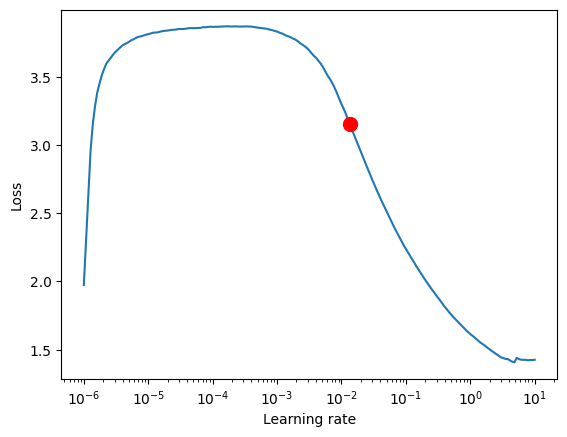

In [15]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
    num_training=200,

)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

configure network and trainer

In [16]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  

    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.014,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 27.6k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [17]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initia

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


clear cheakpoint

In [18]:
import shutil

checkpoint_dir = "/content/trial_1"
shutil.rmtree(checkpoint_dir, ignore_errors=True)
trial_number = 1  # Replace this with the actual trial number
checkpoint_dir = f"/content/trial_{trial_number}"

optimize the hyperparameters

In [21]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=5,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-05-11 07:14:05,680] A new study created in memory with name: no-name-3afa2209-8d56-4287-badb-0e10a2e89d01
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-05-11 07:24:26,070] Trial 0 finished with value: 0.33106106519699097 and parameters: {'gradient_clip_val': 0.4863911394067261, 'hidden_size': 24, 'dropout': 0.19147649615432144, 'hidden_continuous_size': 15, 'attention_head_size': 4, 'learning_rate': 0.0017738717596386382}. Best is trial 0 with value: 0.33106106519699097.
INFO:pyt

{'gradient_clip_val': 0.4863911394067261, 'hidden_size': 24, 'dropout': 0.19147649615432144, 'hidden_continuous_size': 15, 'attention_head_size': 4, 'learning_rate': 0.0017738717596386382}


Test model

In [22]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

Plot the results

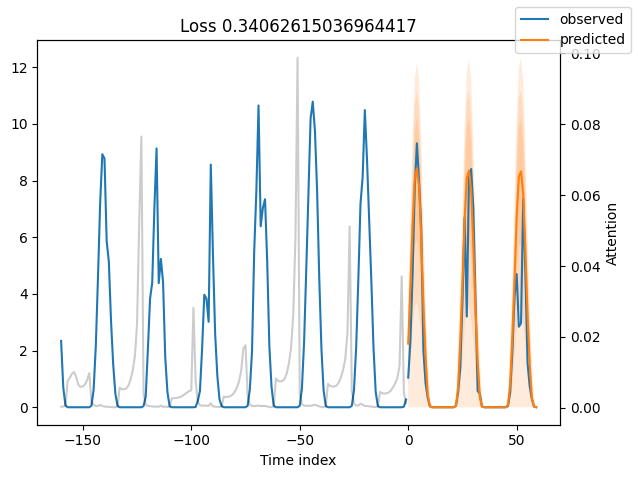

In [24]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:1888: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unr

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'uvi_center': <Figure size 1000x500 with 2 Axes>,
 'uvi_scale': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'uvi': <Figure size 1000x500 with 2 Axes>,
 'wind_d': <Figure size 1000x500 with 2 Axes>,
 'windspd': <Figure size 1000x500 with 2 Axes>,
 'windspd_max': <Figure size 1000x500 with 2 Axes>,
 'temp': <Figure size 1000x500 with 2 Axes>,
 'rh': <Figure size 1000x500 with 2 Axes>,
 'pressure': <Figure size 1000x500 with 2 Axes>,
 'rainfall': <Figure size 1000x500 with 2 Axes>,
 'GHI': <Figure size 1000x500 with 2 Axes>,
 'DNI': <Figure size 1000x500 with 2 Axes>,
 'DHI': <Figure size 1000x500 with 2 Axes>,
 'uva': <Figure size 1000x500 with 2 Axes>,
 'cloud_amount': <Figure size 1000x500 with 2 Axes>}

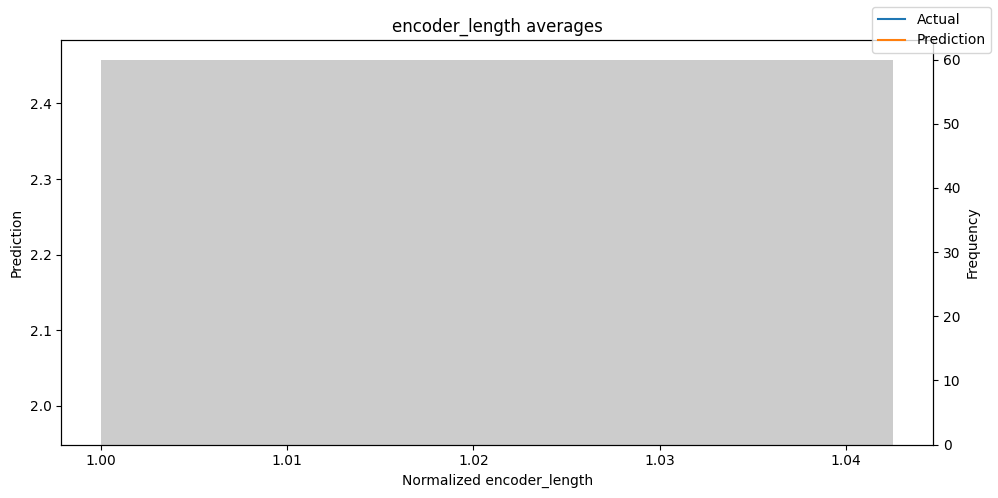

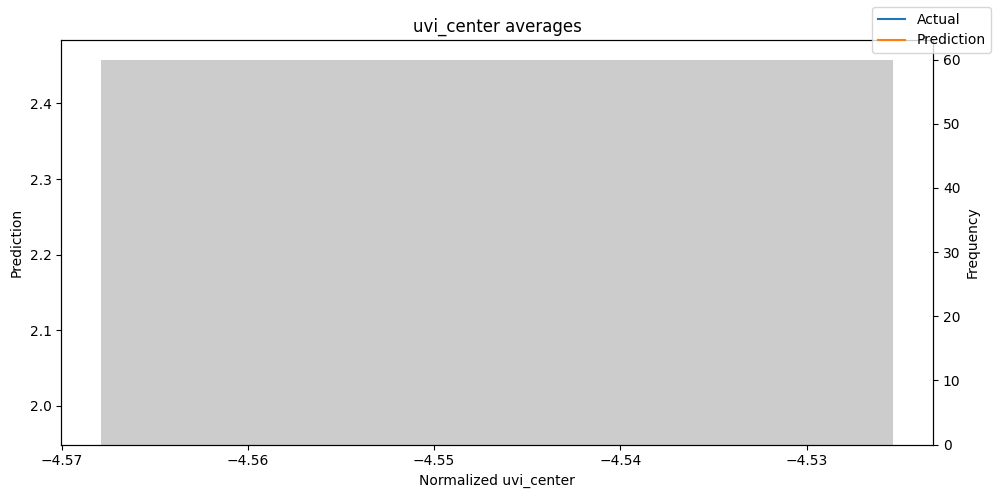

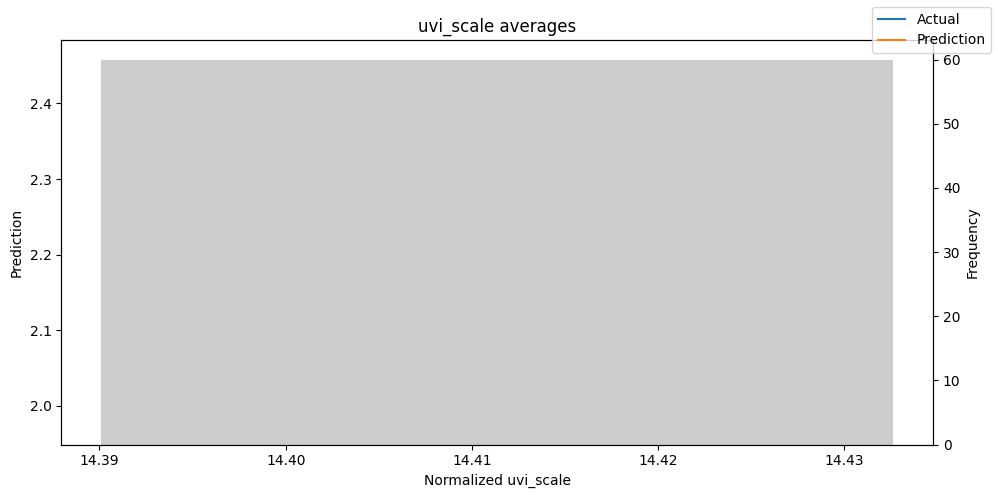

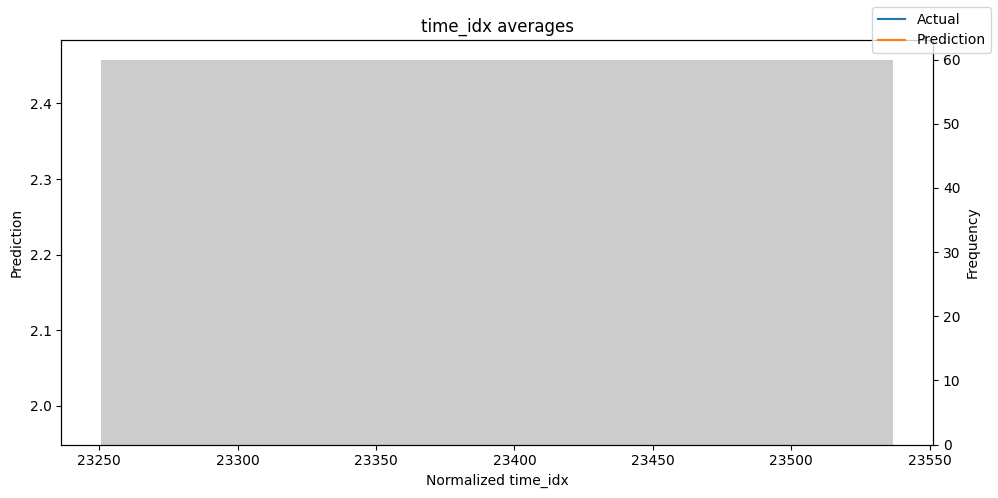

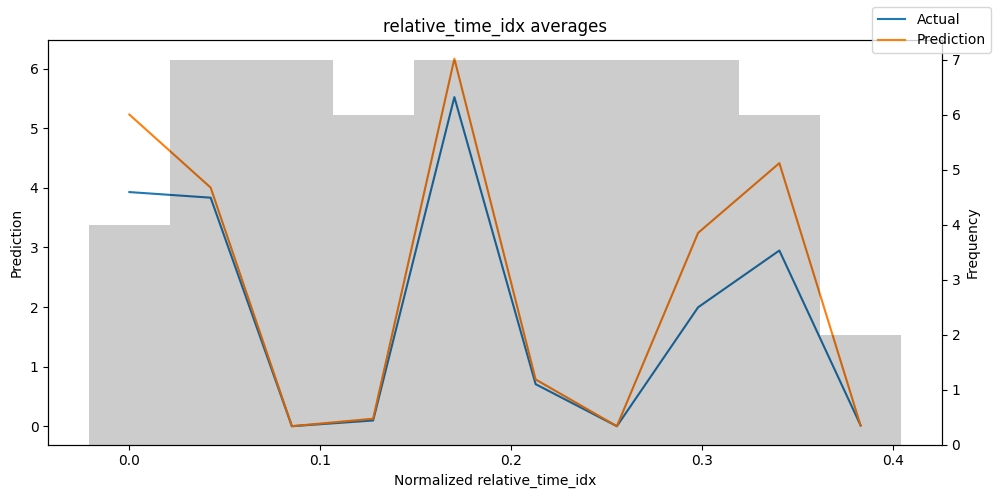

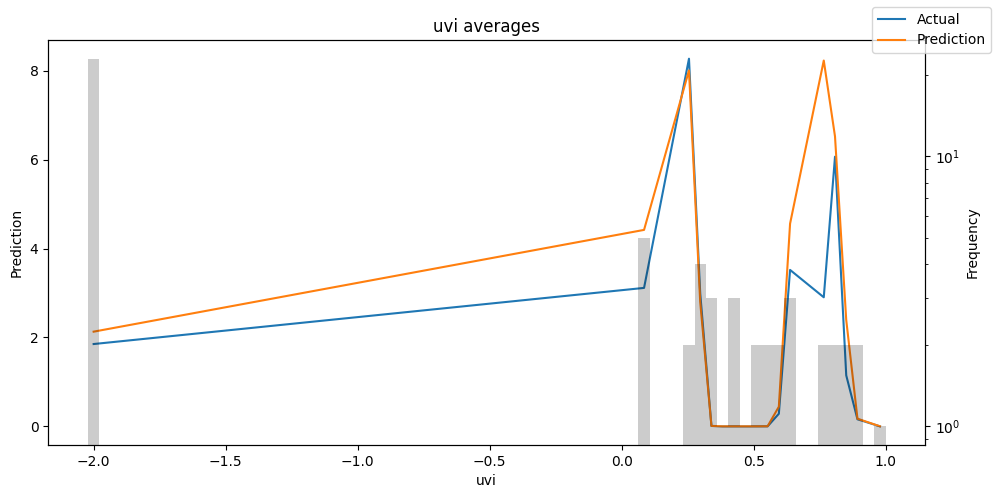

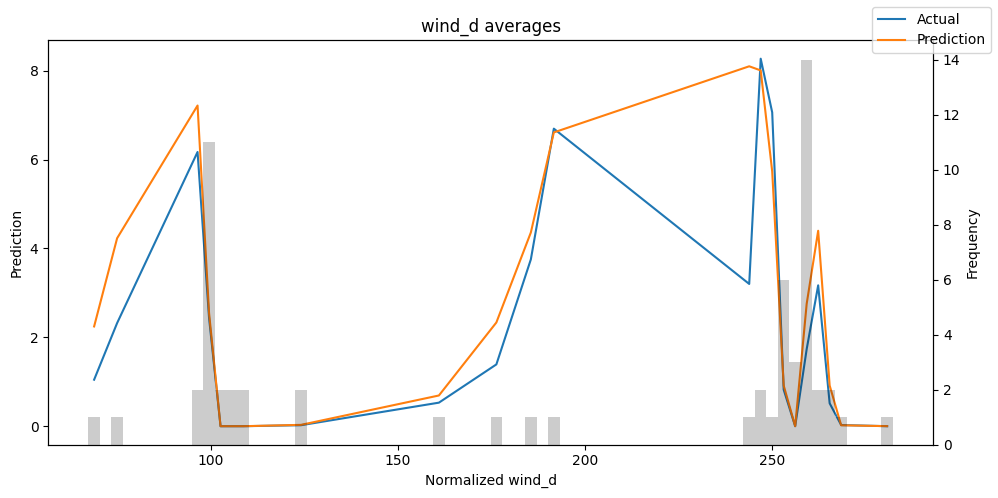

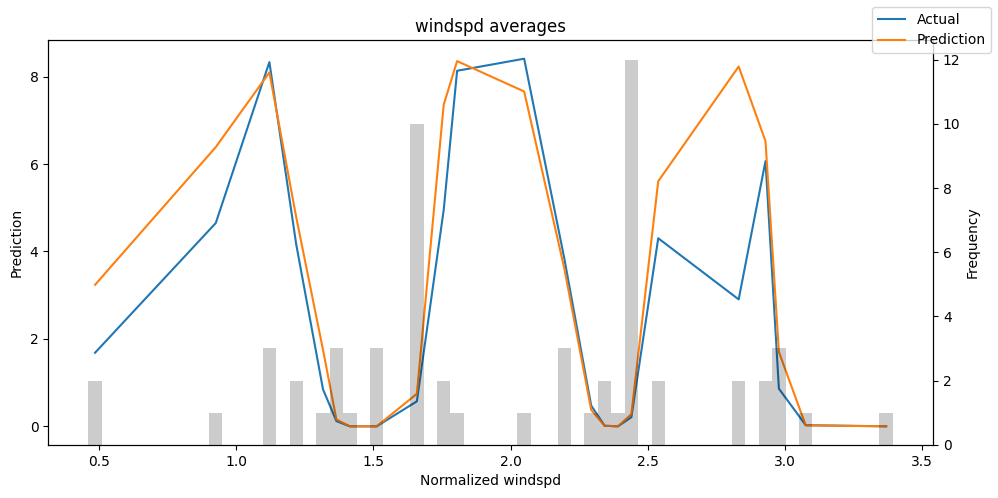

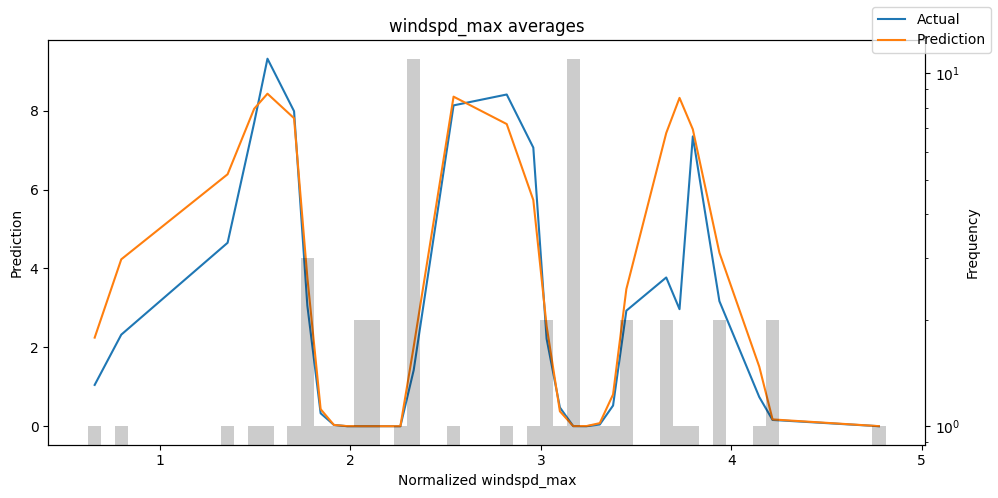

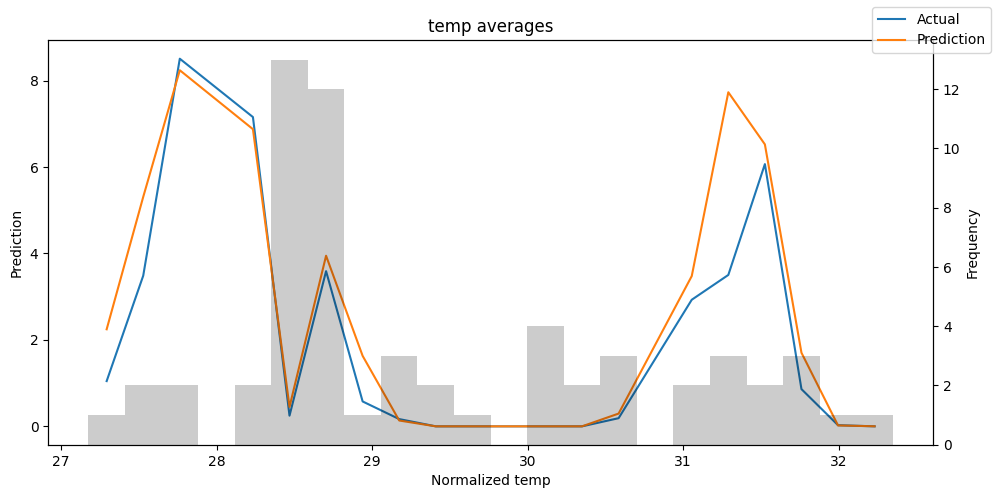

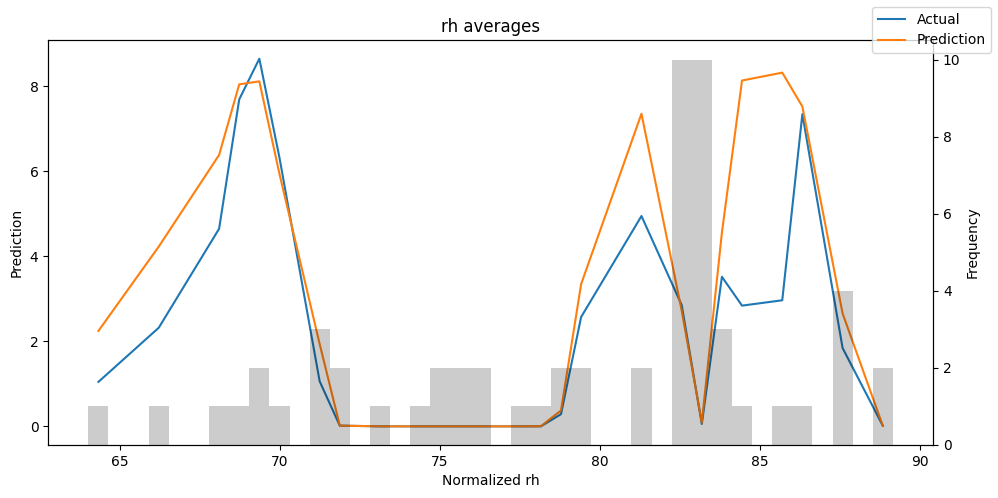

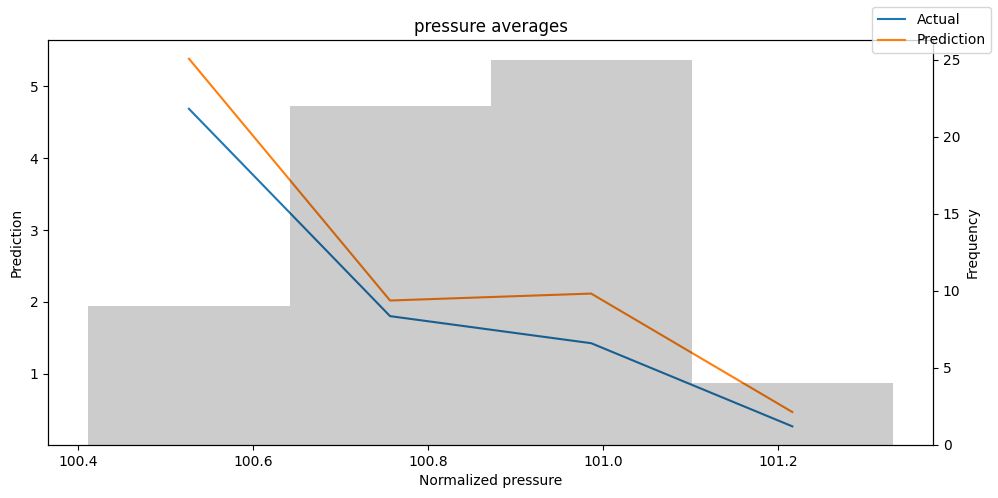

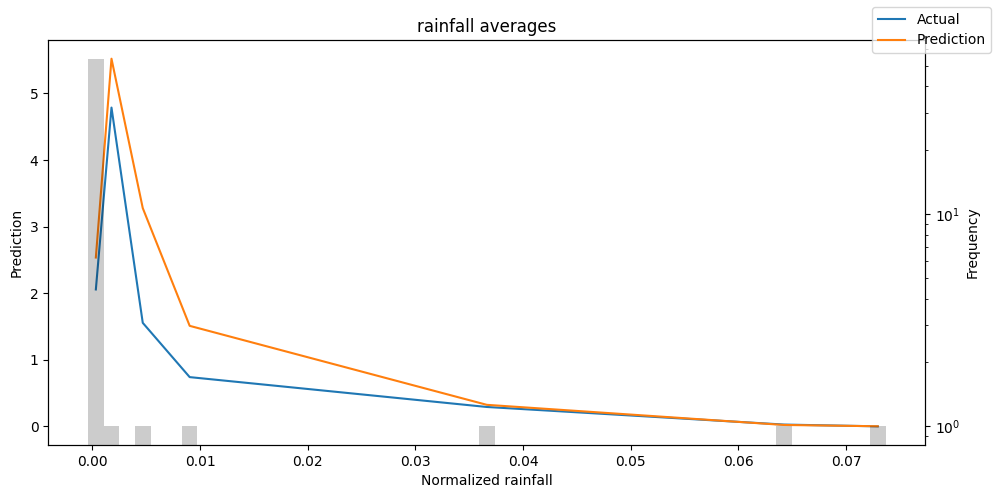

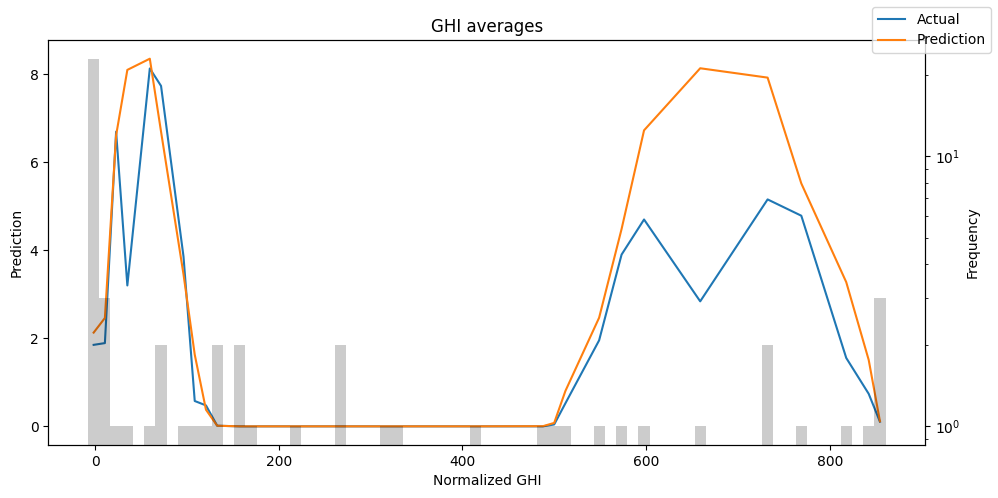

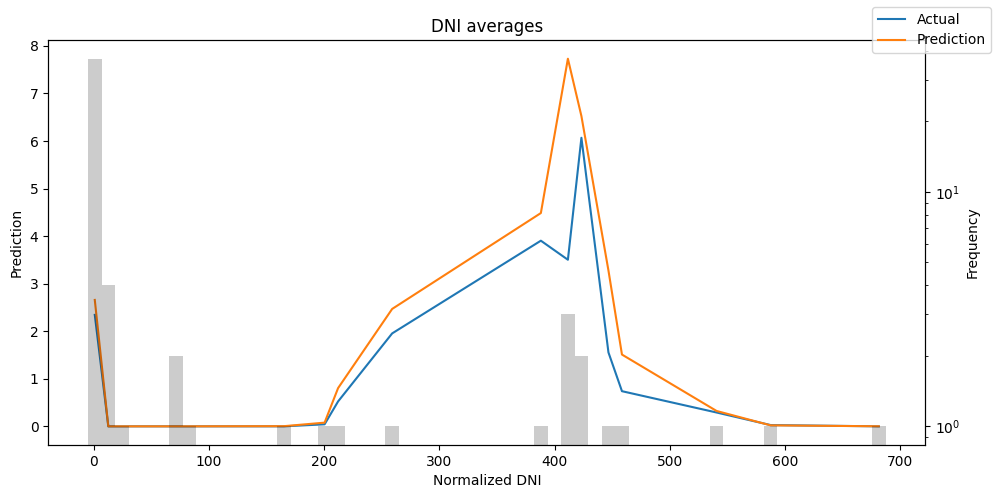

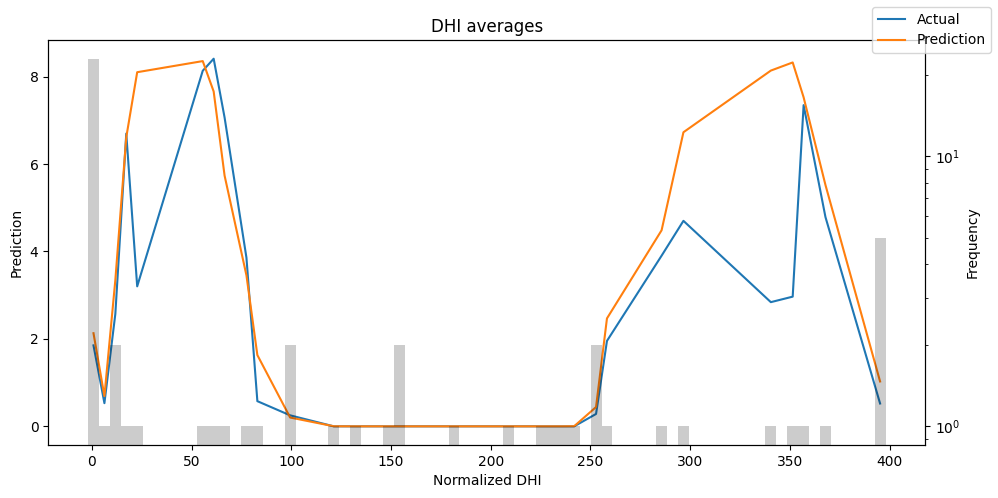

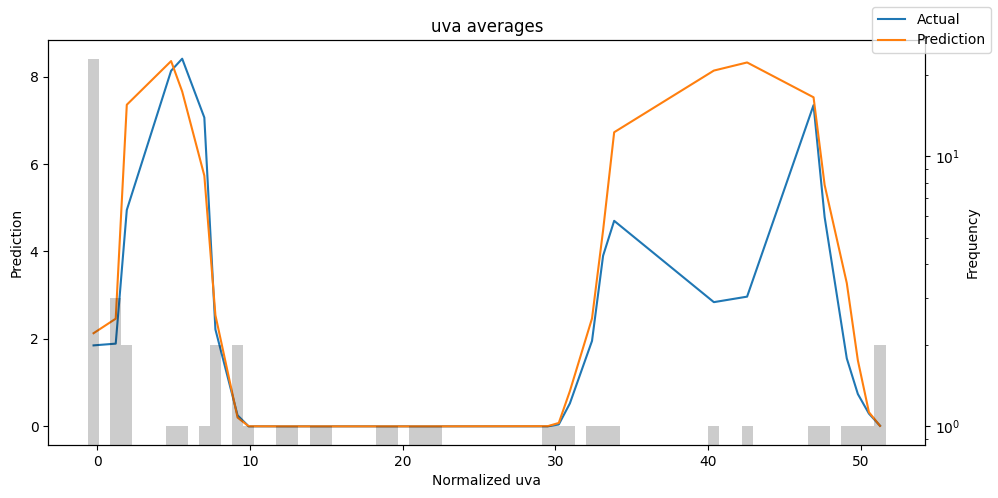

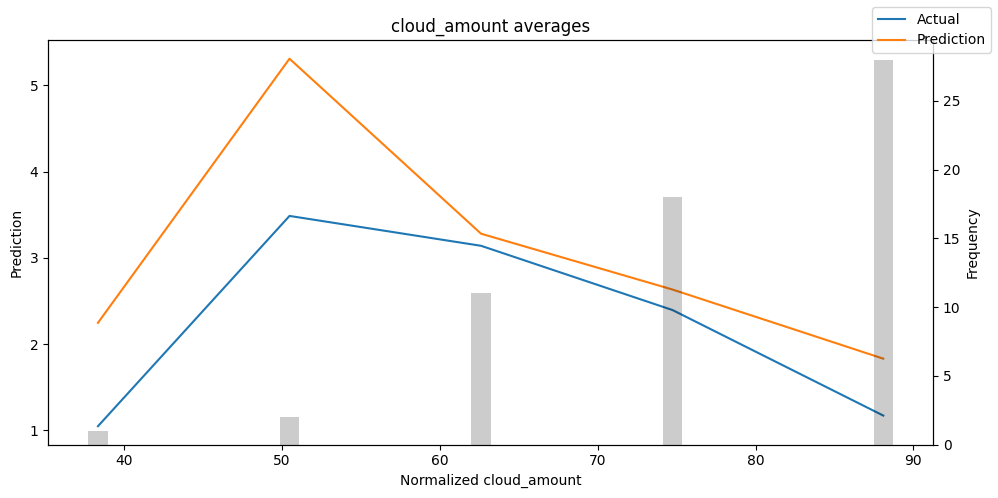

In [25]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

Interpretation results

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x575 with 1 Axes>,
 'decoder_variables': <Figure size 700x250 with 1 Axes>}

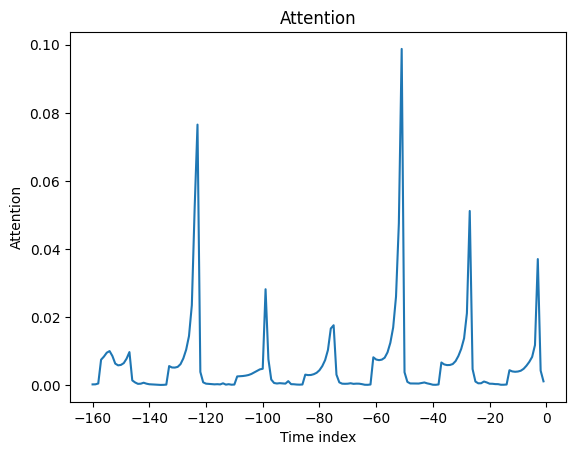

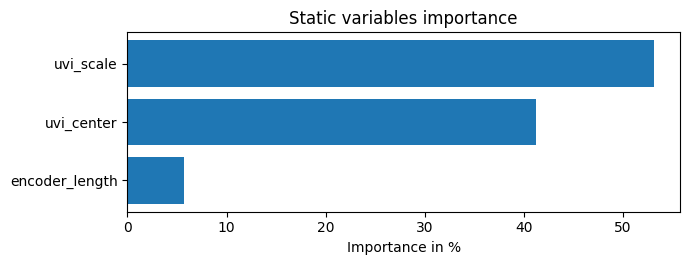

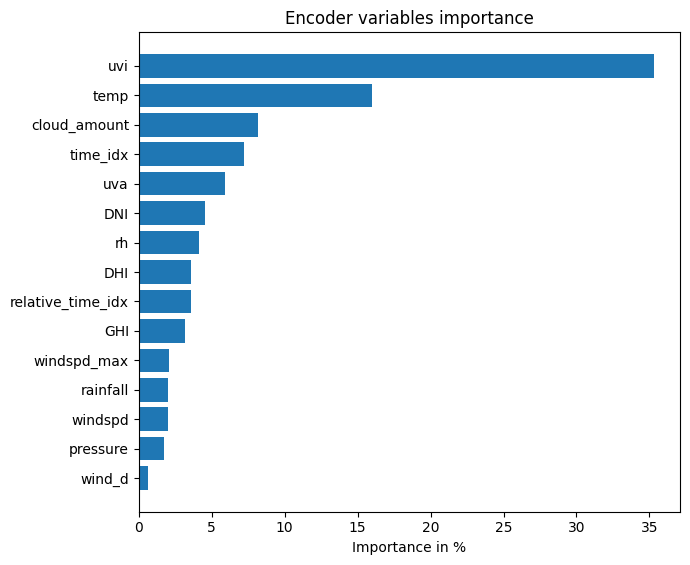

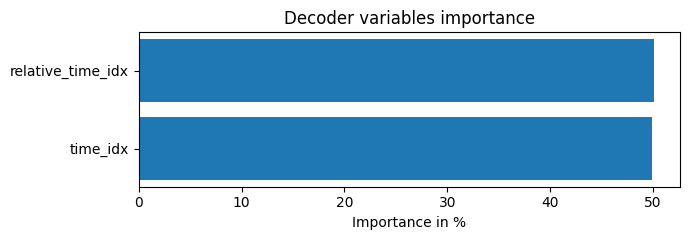

In [26]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)